# Testing of SAMueL-1 synthetic data: Compare differences between synthetic data and real data nearest-neighbours

This notebook shows some examples of synthetic data alongside the nearest-neighbour real data used to create the synthetic data, and show the distribution of distances between real data point nearest neighbours and nearest neighbour distances between synthetic and real data points. Distance between real and synthetic data is measured as Cartesian distance between standardised data for admissions to the same stroke unit.

We look at synthetic data produced directly from real data, and 'double synthetic' data - which is data produced from the first round of synthetic data.

## Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Turn warnings off to keep notebook clean
import warnings

warnings.filterwarnings("ignore")

## Load data

In [2]:
data_loc = './../data/sam_1/kfold_5fold/'

train = pd.read_csv(data_loc + 'train_0.csv')
test = pd.read_csv(data_loc + 'test_0.csv')
synthetic = pd.read_csv(data_loc + 'synthetic_0.csv')
synthetic_double = pd.read_csv(data_loc + 'synthetic_double_0.csv')

X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
X_synthetic = synthetic.drop('S2Thrombolysis', axis=1)
X_synthetic_double = synthetic_double.drop('S2Thrombolysis', axis=1)

## Functions

### Function to standardise data

In [3]:
def standardise_data(X_train, X_test):
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std = sc.transform(X_train)
    test_std = sc.transform(X_test)

    return train_std, test_std

### Function to find closest data points

In [4]:
def find_distance_to_closest_real_data(X_actual, X_synthetic):
    """
    Find nearest neighbour in the real data set (based on Cartesian distance of
    standardised data).
    """

    # Standardise data (based on real training data)
    X_actual_std, X_synth_std = standardise_data(
        X_actual, X_synthetic)

    # Use ScitLearn neighbors.NearestNeighbors to get nearest neighbour
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_actual_std)
    dists, idxs = nn.kneighbors(X_synth_std)

    # Convert row idxs to index in original index in X_actual
    real_ids = list(X_actual.iloc[idxs.flatten()].index)

    # Store in dictionary
    nearest_neighbours = dict()
    nearest_neighbours['distances'] = list(dists.flatten())
    nearest_neighbours['ids'] = real_ids

    return nearest_neighbours

## Get closest distances between real data points, and between synthetic and real data

### Standardise real (X_train) data and set up nearest neighbour algorithm

In [5]:
X_actual_std, X_actual_std = standardise_data(
    X_train.drop('StrokeTeam', axis=1),
    X_train.drop('StrokeTeam', axis=1))

In [6]:
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_actual_std)

### Get nearest neighbours in real data

In [7]:
# Get closest neighbours in real data
dists, idxs = nn.kneighbors()
dist_real_real = dists.flatten()
indx_real_real = idxs.flatten()

### Get nearest neighbours between synthetic data and real data

(Using synthetic data produced directly from real data).

In [8]:
# Get closest neighbours between synthetic and real data
X_actual_std, X_synthetic_std = standardise_data(
    X_train.drop('StrokeTeam', axis=1),
    X_synthetic.drop('StrokeTeam', axis=1))

dists, idxs = nn.kneighbors(X_synthetic_std)
dist_synthetic_real = dists.flatten()
indx_synthetic_real = idxs.flatten()

### Get nearest neighbours between double synthetic data and real data

(Using synthetic data produced directly from synthetic data).

In [9]:
# Get closest neighbours between double synthetic and real data
X_actual_std, X_synthetic_double_std = standardise_data(
    X_train.drop('StrokeTeam', axis=1),
    X_synthetic_double.drop('StrokeTeam', axis=1))

dists, idxs = nn.kneighbors(X_synthetic_double_std)
dist_synthetic_double_real = dists.flatten()
indx_synthetic_double_real = idxs.flatten()

### Plot histogram of distances to nearest real data point

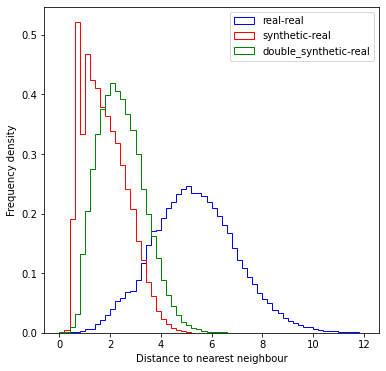

In [10]:
bins = np.arange(0, 12.1, 0.2)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist(dist_real_real, bins=bins, histtype='step', color='b', 
        density=True, label='real-real')
ax.hist(dist_synthetic_real, bins=bins, histtype='step', color='r', 
        density=True, label='synthetic-real')
ax.hist(dist_synthetic_double_real, bins=bins, histtype='step', color='g', 
        density=True, label='double_synthetic-real')

ax.set_xlabel('Distance to nearest neighbour')
ax.set_ylabel('Frequency density')
ax.legend()
plt.savefig('./images/distance_comparison.png', dpi=300)
plt.show()

## Summary statistics

In [11]:
summary = pd.DataFrame(columns=[
    'Real-Real', 'Synthetic-Real', 'Double synthetic-Real'], index=['mean', 'stdev'])
summary['Real-Real']['mean'] = dist_real_real.mean().round(2)
summary['Real-Real']['stdev'] = dist_real_real.std().round(2)
summary['Synthetic-Real']['mean'] = dist_synthetic_real.mean().round(2)
summary['Synthetic-Real']['stdev'] = dist_synthetic_real.std().round(2)
summary['Double synthetic-Real']['mean'] = dist_synthetic_double_real.mean().round(2)
summary['Double synthetic-Real']['stdev'] = dist_synthetic_double_real.std().round(2)
summary.T

,mean,stdev
Real-Real,5.34,1.68
Synthetic-Real,1.8,0.88
Double synthetic-Real,2.44,0.93


## Show proportion of points that are identical to real data

In [12]:
# Count identical points between real and synthetic data
identical = np.mean(dist_synthetic_real < 0.001)
print(
    f'Proportion identical between real and synthetic data: {identical:0.3f}')

# Count identical points between real and double synthetic data
identical = np.mean(dist_synthetic_double_real < 0.001)
print(
    f'Proportion identical between real and double synthetic data: {identical:0.3f}')

Proportion identical between real and synthetic data: 0.000
Proportion identical between real and double synthetic data: 0.000


## Show near neighbour examples between real data

In [13]:
# Sample 4 real data points
np.random.RandomState=42
sample_index = np.random.choice(np.arange(len(X_train)), 4)
real_samples_a = X_train.iloc[sample_index]
closest_neigbour_index = indx_real_real[sample_index]
real_samples_b = X_train.iloc[closest_neigbour_index]
real_sample_differences = dist_real_real[sample_index]

# Save
real_samples_a.to_csv('./synth_examples/real_samples_a.csv')
real_samples_b.to_csv('./synth_examples/real_samples_a_nn.csv')

In [14]:
# Standardise
cols = list(X_train.drop('StrokeTeam', axis=1))
X_train_std, real_samples_a_std = standardise_data(
    X_train[cols], real_samples_a[cols])
X_train_std, real_samples_b_std = standardise_data(
    X_train[cols], real_samples_b[cols])

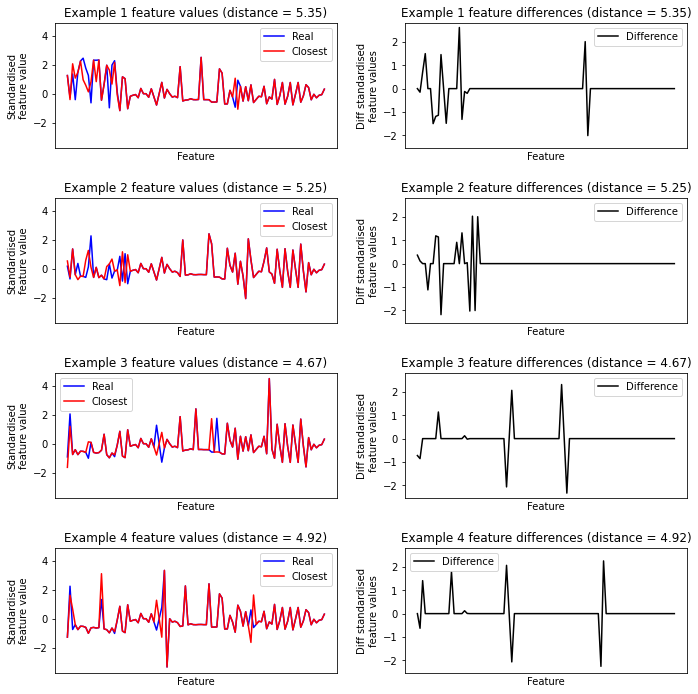

In [15]:
# Get axis limits
value_min = min(np.min(real_samples_a_std), np.min(real_samples_b_std)) - 0.4
value_max = max(np.max(real_samples_a_std), np.max(real_samples_b_std)) + 0.4
diff = real_samples_b_std - real_samples_a_std
diff_min = np.min(diff) - 0.2
diff_max = np.max(diff) + 0.2

fig, ax = plt.subplots(4, 2, figsize=(10, 10))
ax = ax.ravel()
for i in range(4):
    row = i
    y1 = real_samples_a_std[i]
    y2 = real_samples_b_std[i]
    x = range(len(y1))
    ax[row * 2].plot(x, y1, color='b', label='Real')
    ax[row * 2].plot(x, y2, color='r', linestyle='-', label='Closest')
    ax[row * 2].get_xaxis().set_ticks([])
    ax[row * 2].set_xlabel('Feature')
    ax[row * 2].set_ylabel('Standardised\nfeature value')
    ax[row * 2].set_ylim(value_min, value_max)
    distance = real_sample_differences[i]
    title = f'Example {i + 1} feature values (distance = {distance:0.2f})'
    ax[row * 2].set_title(title)
    ax[row * 2].legend()

    y = y = real_samples_b_std[i] - real_samples_a_std[i]
    x = range(len(y1))
    ax[row * 2 + 1].plot(x, y, color='k', label='Difference')
    ax[row * 2 + 1].get_xaxis().set_ticks([])
    ax[row * 2 + 1].set_xlabel('Feature')
    ax[row * 2 + 1].set_ylabel('Diff standardised\nfeature values')
    ax[row * 2 + 1].set_ylim(diff_min, diff_max)
    title = f'Example {i + 1} feature differences (distance = {distance:0.2f})'
    ax[row * 2 + 1].set_title(title)
    ax[row * 2 + 1].legend()

plt.tight_layout(pad=2)
fig.patch.set_facecolor('w')
plt.savefig('./images/nn_examples_real_to_real.png', dpi=300)
plt.show()

## Show near neighbour examples between (double) synthetic data and real data

In [16]:
# Sample 4 double synthetic data points
np.random.RandomState=42
sample_index = np.random.choice(np.arange(len(X_synthetic_double)), 4)
synth_examples = X_synthetic_double.iloc[sample_index]
closest_neigbour_index = indx_synthetic_double_real[sample_index]
real_examples = X_train.iloc[closest_neigbour_index]
real_synthetic_differences = dist_synthetic_double_real[sample_index]

# Save
synth_examples.to_csv('./synth_examples/synth_examples.csv')
real_examples.to_csv('./synth_examples/closest_real.csv')

In [17]:
# Standardise
cols = list(X_train.drop('StrokeTeam', axis=1))
X_train_std, real_examples_std = standardise_data(
    X_train[cols], real_examples[cols])
X_train_std, synth_examples_std = standardise_data(
    X_train[cols], synth_examples[cols])

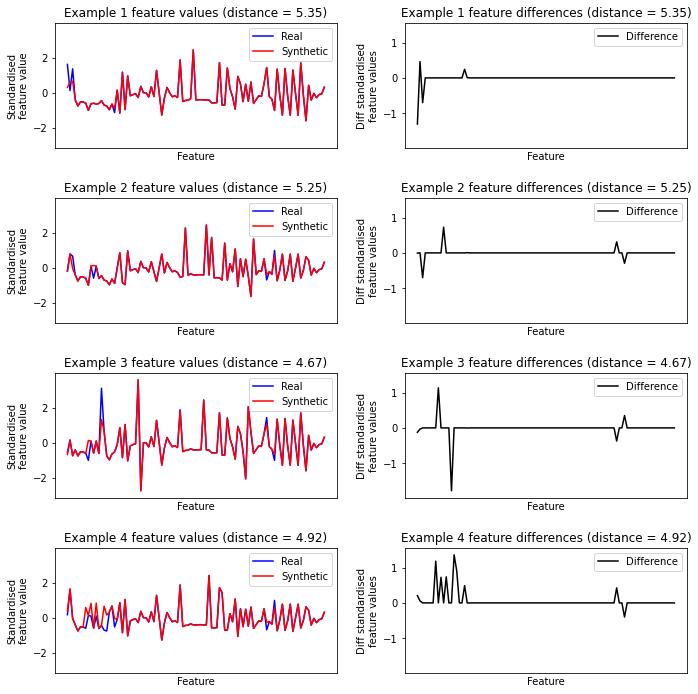

In [18]:
# Get axis limits
value_min = min(np.min(real_examples_std), np.min(synth_examples_std)) - 0.4
value_max = max(np.max(real_examples_std), np.max(synth_examples_std)) + 0.4
diff = synth_examples_std - real_examples_std
diff_min = np.min(diff) - 0.2
diff_max = np.max(diff) + 0.2

fig, ax = plt.subplots(4, 2, figsize=(10, 10))
ax = ax.ravel()
for i in range(4):
    row = i
    y1 = real_examples_std[i]
    y2 = synth_examples_std[i]
    x = range(len(y1))
    ax[row * 2].plot(x, y1, color='b', label='Real')
    ax[row * 2].plot(x, y2, color='r', linestyle='-', label='Synthetic')
    ax[row * 2].get_xaxis().set_ticks([])
    ax[row * 2].set_xlabel('Feature')
    ax[row * 2].set_ylabel('Standardised\nfeature value')
    ax[row * 2].set_ylim(value_min, value_max)
    distance = real_sample_differences[i]
    title = f'Example {i + 1} feature values (distance = {distance:0.2f})'
    ax[row * 2].set_title(title)
    ax[row * 2].legend()

    y = synth_examples_std[i] - real_examples_std[i]
    x = range(len(y1))
    ax[row * 2 + 1].plot(x, y, color='k', label='Difference')
    ax[row * 2 + 1].get_xaxis().set_ticks([])
    ax[row * 2 + 1].set_xlabel('Feature')
    ax[row * 2 + 1].set_ylabel('Diff standardised\nfeature values')
    ax[row * 2 + 1].set_ylim(diff_min, diff_max)
    title = f'Example {i + 1} feature differences (distance = {distance:0.2f})'
    ax[row * 2 + 1].set_title(title)
    ax[row * 2 + 1].legend()

plt.tight_layout(pad=2)
fig.patch.set_facecolor('w')
plt.savefig('./images/nn_examples.png', dpi=300)
plt.show()

## Observations

* The nearest neighbour distance between synthetic and real data points is generally smaller than the nearest neighbour distance between real data points.

* The use of double synthetic data avoids a peak of synthetic data that has close proximity to real data.

* There are no identical points in the real data or between real and synthetic data (of either type). 